In [1]:
# import the required packages
# packages can be easily installed by setting up an Anaconda environment with the included .yml file
# see instructions at: https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html

import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from pykeops.torch import LazyTensor
import kornia as K

If a CUDA device is available, it will be selected.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We begin by defining a helper function which returns a function that retrieves values from a particular image. Coordinates will be passed as an N x 2 tensor (int64 datatype). Implement your own gen_sampler/sampler function with your microscope API so that you can easily incorporate the sampler.

In [3]:
def gen_sampler(image_tensor):
    assert len(image_tensor.shape) == 2
    def sampler(coords):
        return image_tensor[coords[:, 0], coords[:, 1]]
    return sampler

Here we define a helper function to normalize, resize, and display tensors as uint8 type images

In [4]:
def show_tensor(tensor, resize=False, size=(256, 256), norm=True):
    if norm:
        tensor = (tensor - tensor.min())/(tensor.max()-tensor.min())
    if resize:
        img = Image.fromarray((K.utils.tensor_to_image(tensor)*255.0).astype(np.uint8)).resize(size)
    else:
        img = Image.fromarray((K.utils.tensor_to_image(tensor)*255.0).astype(np.uint8))
    display(img)

We load a provided example image, and pass it to the sampler_maker function, and use our helper function to display the image.

torch.Size([600, 600])


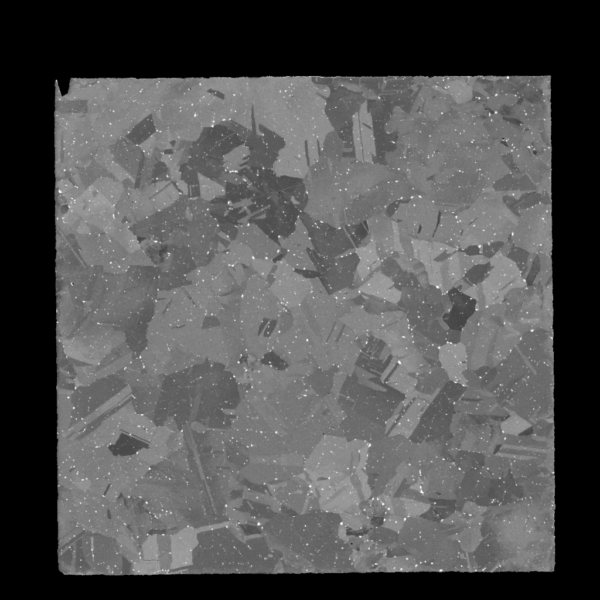

In [5]:
# load the tif image using PIL, transform to numpy array then PyTorch tensor, then put to device
image_object = Image.open('image_BSE.tif')
image_tensor = torch.tensor(np.array(image_object).astype(np.float32)).to(device)

# normalize image
image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
# print the shape
print(image_tensor.shape)
# display the image
show_tensor(image_tensor)

# pass it to a sampler function
my_sampler = gen_sampler(image_tensor)

Next we define the main class that performs dynamic sampling.

In [6]:
class DynamicSampler:
    def __init__(self, sampler, region_shape, K, device):
        self.sampler = sampler
        self.region_shape = region_shape
        self.count = region_shape[0] * region_shape[1]
        self.device = device
        self.K = K
        
        # indicator if random initial sampling has been done
        self.started = False
        
        # (M) boolean indicator if sampled
        self.is_sampled = torch.zeros(self.count, dtype=torch.bool, device=self.device)
        
        # (M, 2) list of all possible coordinates
        X = torch.arange(self.region_shape[0]).to(device)
        Y = torch.arange(self.region_shape[1]).to(device)
        xg, yg = torch.meshgrid(X, Y, indexing='ij')
        self.coords = torch.stack((xg.contiguous().view(-1), yg.contiguous().view(-1)), dim=1)
        self.indices = torch.arange(self.count, dtype=torch.int64, device=self.device)
        self.indices_shaped = torch.arange(self.count, dtype=torch.int64, device=self.device).reshape(region_shape)
        
        # (N, 2) where N == M to begin with
        self.cur_nn_ind = torch.zeros((self.count, self.K), dtype=torch.int64, device=self.device)
        self.cur_nn_sqd = torch.full((self.count, self.K), torch.inf, dtype=torch.float32, device=self.device)
        self.measurements = torch.full((self.count,), torch.inf, dtype=torch.float32, device=self.device)
        
        # Sobol sampler for intial sample
        self.region_shape_t = torch.tensor(region_shape, device=self.device) - 1.0
        self.sobol = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
        self.sobol_cache = torch.zeros((0, 2), dtype=torch.int64, device=self.device)
        
    def reset(self):
        # reset variables explained in the constructor
        self.started = False
        self.is_sampled = torch.zeros(self.count, dtype=torch.bool, device=self.device)
        X = torch.arange(self.region_shape[0]).to(device)
        Y = torch.arange(self.region_shape[1]).to(device)
        xg, yg = torch.meshgrid(X, Y)
        self.coords = torch.stack((xg.contiguous().view(-1), yg.contiguous().view(-1)), dim=1)
        self.indices = torch.arange(self.count, dtype=torch.int64, device=self.device)
        self.indices_shaped = torch.arange(self.count, dtype=torch.int64, device=self.device).reshape(self.region_shape)
        self.cur_nn_ind = torch.zeros((self.count, self.K), dtype=torch.int64, device=self.device)
        self.cur_nn_sqd = torch.full((self.count, self.K), torch.inf, dtype=torch.float32, device=self.device)
        self.measurements = torch.full((self.count,), torch.inf, dtype=torch.float32, device=self.device)
        self.sobol = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
        
    def get_values(self, coords_new):
        return self.sampler(coords_new)
    
    def kernel_knn(self, coords, query, K):
        # make sure contiguous in memory
        coords = coords.float().contiguous()
        query = query.float().contiguous()
        # find the nearest K neighbors using PyKeOps
        G_i = LazyTensor(query[:, None, :])
        X_j = LazyTensor(coords[None, :, :])
        D_ij = ((G_i - X_j) ** 2).sum(-1)
        return D_ij.Kmin_argKmin(K, dim=1)
    
    def query(self):
        # return the nearest neighbors of all unmeasured pixels
        return self.cur_nn_sqd[~self.is_sampled], self.cur_nn_ind[~self.is_sampled]
    
    def sample_values(self, coords_new):
        # externally get the values using the 2D coordinates
        values_new = self.get_values(coords_new)
        
        # find flat indices for new measurements
        coords_new_flat = self.indices_shaped[coords_new[:, 0], coords_new[:, 1]]
        
        # register that these have been measured and save the values
        self.is_sampled[coords_new_flat] = True
        self.measurements[coords_new_flat] = values_new
        
        # find top k smallest distances from now updated unmeasured list to new coords
        dists_new, indices_new = self.kernel_knn(coords_new, self.coords[~self.is_sampled].float(), self.K)
        # nn_indices_new = self.indices[~self.is_sampled][indices_new]
        nn_indices_new = coords_new_flat[indices_new]
        
        # concatenate to current list of sqdists and global indices
        combined_dists = torch.concat((self.cur_nn_sqd[~self.is_sampled], dists_new), dim=1)
        combined_indices = torch.concat((self.cur_nn_ind[~self.is_sampled], nn_indices_new), dim=1)
        
        # find the winners from the old neighbors and new possible neighbors
        top_dists, top_indices_locals = torch.topk(combined_dists, dim=1, k=self.K, largest =False)
        
        # update new indices of the winners
        # self.cur_nn_ind[~self.is_sampled] = combined_indices[top_indices_locals]
        self.cur_nn_ind[~self.is_sampled] = torch.gather(combined_indices, dim=1, index=top_indices_locals)
        self.cur_nn_sqd[~self.is_sampled] = top_dists
    
    def impute(self, dists, vals, inv_dist_weighted):
        if inv_dist_weighted:
            dists_inv = 1.0 / dists
            weights = dists_inv / torch.sum(dists_inv, dim=1, keepdim=True)
            return (vals * weights).sum(1)
        else:
            return vals.mean(1)

    def score(self, sqdists, values):
        # return the score which is the minimum Euclidian distance times variance of neighbor values
        mdists = sqdists.min(1)[0]**0.5
        std = values.std(1)
        return mdists * std

    def unravel_indices(self, indices, shape):
        shape = indices.new_tensor(shape + (1,))
        coefs = shape[1:].flipud().cumprod(dim=0).flipud()
        return torch.div(indices[..., None], coefs, rounding_mode='trunc') % shape[:-1]

    def peaks(self, scores, window):
        # do 2D non-maximal supression peak-finding on the score-board with window size
        scores_unsq = scores[None, None]
        window_maxima = torch.nn.functional.max_pool2d(scores_unsq, window, 1, padding=window//2, return_indices=True)[1].squeeze()
        candidates = window_maxima.unique()
        peak_indices = candidates[(window_maxima.reshape(-1)[candidates]==candidates).nonzero()][:, 0]
        return self.unravel_indices(peak_indices, self.region_shape)

    def scored_sample(self, start, window, batch_fraction):
        # random sample to start if not yet done
        if not self.started:
            self.started = True
            win_coords = (self.sobol.draw(start).to(self.device) * self.region_shape_t).type(torch.int64)
        # scored sampling otherwise
        else:
            dists, indices = self.query()
            vals = self.measurements[indices]
            scores = self.score(dists, vals)
            flat_score_board = torch.full((self.count,), -1.0e10, dtype=torch.float32, device=self.device)
            flat_score_board[~self.is_sampled] = scores
            score_board = flat_score_board.reshape(self.region_shape)
            best_coords = self.peaks(score_board, window)
            best_scores = score_board[best_coords[:,0], best_coords[:,1]]
            # determine how many winners are selected
            b = max(int(len(best_coords) * batch_fraction), 1)
            # take a certain number of the best of them
            win_coords = best_coords[torch.topk(best_scores, b).indices]
        # measure the winning coordinates
        self.sample_values(win_coords)
        # return the coordinates chosen
        return win_coords

    def dynamic_sample_to_fraction(self, stopping_fraction, start=4096, window=3, batch_fraction=0.25, reset=True):
        selected_coords = []
        wall_times = []
        cur_window = window
        while self.is_sampled.sum() < (stopping_fraction * self.region_shape[0] * self.region_shape[1]):
            win_coords = self.scored_sample(start, window, batch_fraction)
            selected_coords.append(win_coords.clone())
            wall_times.append(time.time())
        if reset:
            self.reset()
        return selected_coords, wall_times
    
    def sobol_sample(self, num_samples):
        win_coords = torch.tensor([], dtype=torch.int64, device=self.device)
        while num_samples > len(self.sobol_cache):
            fresh_sobol_batch = (self.sobol.draw(num_samples).to(self.device) * self.region_shape_t).type(torch.int64)
            combined_sobol_cache = torch.cat((self.sobol_cache, fresh_sobol_batch), dim=0).unique(dim=0, sorted=False)
            sobol_cache_flat = self.indices_shaped[combined_sobol_cache[:, 0], combined_sobol_cache[:, 1]]
            self.sobol_cache = combined_sobol_cache[~self.is_sampled[sobol_cache_flat]]
        win_coords = self.sobol_cache[:num_samples]
        self.sobol_cache = self.sobol_cache[num_samples:]
        self.sample_values(win_coords)
        return win_coords
    
    def sobol_sample_to_fraction(self, stopping_fraction, batch_size, reset=True):
        selected_coords = []
        wall_times = []
        while self.is_sampled.sum() < (stopping_fraction * self.region_shape[0] * self.region_shape[1]):
            win_coords = self.sobol_sample(batch_size)
            selected_coords.append(win_coords.clone())
            wall_times.append(time.time())
        if reset:
            self.reset()
        return selected_coords, wall_times

    def tensor_infill(self, inv_dist_weighted):
        dists, indices = self.query()
        neigh_vals = self.measurements[indices]
        imputed_vals = self.impute(dists, neigh_vals, inv_dist_weighted)
        frame = torch.empty((self.count,), dtype=torch.float32, device=self.device)
        frame[self.is_sampled] = self.measurements[self.is_sampled]
        frame[~self.is_sampled] = imputed_vals
        return frame.view(self.region_shape)
    
    def sampled_infill(self):
        frame = self.is_sampled
        return frame.view(self.region_shape)
    
    def replay_PSNR(self, ground_truth, coords, movie=False, frame_shape=None, reset=True, inv_dist_weighted=True):
        percent_changes = [len(r) / (self.region_shape[0] * self.region_shape[1]) for r in coords]
        percents = torch.cumsum(torch.tensor(percent_changes), dim=0)
        psnrs = []
        if movie:
            resizer = K.geometry.transform.Resize(frame_shape)
            frames = []
        for new_coords in coords:
            self.sample_values(new_coords)
            full_frame = self.tensor_infill(inv_dist_weighted)
            psnr = -10.0*torch.log10(((full_frame - ground_truth)**2).mean())
            psnrs.append(psnr.item())
            if movie:
                frames.append((resizer(full_frame[None, None])[0,0] * 255.0)[:,:,None].repeat(1,1,3).byte())
        if reset:
            self.reset()
        if movie:
            return percents, psnrs, frames
        else:
            return percents, psnrs

Now we can run the sampler and then replay the sampling with infilled frames to make a gif showing sampling progression.

In [14]:
# define our parameter for stopping (a fraction of total image pixels)
stopping_fraction = 0.5

# construct the sampler class
DS = DynamicSampler(sampler=my_sampler, region_shape=image_tensor.shape, K=3, device=device)
# run the sampling and recieve the coordinate locations and runtimes
coordinate_batches, wall_times = DS.dynamic_sample_to_fraction(stopping_fraction, reset=True)

# create a movie for the sampling
fractions, psnrs, frames = DS.replay_PSNR(image_tensor, coordinate_batches, movie=True, frame_shape=(256,256))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [21]:
# print the runtime in seconds
print("Runtime: " , wall_times[-1] - wall_times[0], " seconds")
# change the frames from tensors on the GPU to numpy arrays on the CPU to image objects
movie = [Image.fromarray(frame.cpu().numpy()) for frame in frames]
# save the movie as a .gif file
name = 'tutorial_movie.gif'
movie[0].save(name, save_all=True, append_images=movie[1:], optimize=False, duration=1000, loop=0)

Runtime:  0.5906307697296143  seconds


Text(0.5, 0, 'Percents')

Text(0, 0.5, 'PSNR')

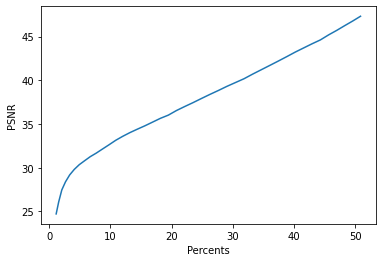

In [22]:
# plot percents versus PSNR
plt.plot(100*fractions, psnrs)
plt.xlabel('Percents')
plt.ylabel('PSNR')
plt.show()

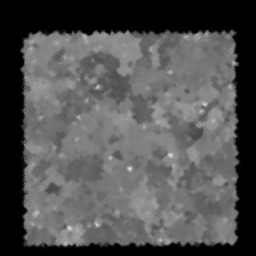

In [24]:
# import required IPython libs/settings and show the animation
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

with open(name,'rb') as f:
    display.Image(data=f.read(), format='png')